# Install 

In [1]:
! pip install memory_profiler
%load_ext memory_profiler 

Defaulting to user installation because normal site-packages is not writeable


# Import 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearnex import patch_sklearn  # Speeds up sklearn with intel patch
patch_sklearn()  # Activate patch - changes sklearn imports below

from timeit import default_timer as timer # Time how long commands take
from sklearn.model_selection import train_test_split, StratifiedKFold  # test_train split, cross-validation

from sklearn.experimental import enable_iterative_imputer  # Iterative imputer experimental so need to enable it
from sklearn.impute import IterativeImputer  # Once enabled iterative imputer can be imported

from sklearn.linear_model import RidgeClassifier, BayesianRidge  # Imputation
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder  # Normalisation & Encoding
from imblearn.under_sampling import TomekLinks  # Undersampling
from imblearn.over_sampling import SMOTENC  # Oversampling
from sklearn.feature_selection import RFE, RFECV  # Recursive feature elimination - feature selection
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier  # RFE
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from imblearn.pipeline import Pipeline as imbpipeline

from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Random State

In [3]:
random_state=14

# General Functions

In [4]:
# Stopwatch to profile function runtimes
class Stopwatch:

    # Initiate constructor
    def __init__(self):
        self.start = timer()
        self.end = None
        self.runtime = None

    # Stop stopwatch
    def stop(self):
        self.end = timer()
        self.runtime = self.end - self.start
        return self.runtime

# Data Cleaning

In [5]:
# Read in data
df = pd.read_csv('/data/home/bt211037/dissertation/supervised_ML_data.tsv',
                   sep='\t', header=0, index_col=0)


### Test Train Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'thyroid_cancer'],
                                                        df['thyroid_cancer'],
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=random_state,
                                                        stratify=df['thyroid_cancer'])



### Convert categorical columns to integers

In [7]:
# Find which columns are categorical and which continuous
def cat_con_cols(df):
    columns = [list(df[i]) for i in df]  # Nested list of column values
    num_unique_vals = [len(set([i for i in a if pd.notna(i)])) for a in columns]  # Num of unique values in a column

    categorical_indexes = [i for i, v in enumerate(num_unique_vals) if v <= 100
                           and set([a % 1 for a in df[df.columns[i]].dropna()]) == {0}]

    continuous_indexes = [i for i, v in enumerate(num_unique_vals) if v > 100 or
                          set([a % 1 for a in df[df.columns[i]].dropna()]) != {0}]

    cat = list(df.columns[categorical_indexes])
    con = list(df.columns[continuous_indexes])
    return cat, con


In [8]:
cat, con = cat_con_cols(X_train)  # Get the column names of the continuous and nominal data
X_train[cat] = X_train[cat].astype('Int64')  # Convert categorical cols values from floats to integers - train
X_test[cat] = X_test[cat].astype('Int64')  # Convert categorical cols values from floats to integers - test



### Separate categorical and Continuous features in dataframe¶

This makes indexing certain features in later processess easier.


In [9]:
X_train = pd.concat([X_train[con], X_train[cat]], axis=1, join="inner")

# Pipeline

In [10]:
# Column indexes for categorical and continuous features
categorical_indexes = [i for i, x in enumerate(X_train.columns) if x in cat]
continuous_indexes = [i for i, x in enumerate(X_train.columns) if x in con]



In [11]:
# Ridge Classifier model used for RFE
model = ExtraTreesClassifier(n_estimators=100, n_jobs=10, 
                             random_state=random_state)


In [12]:
#model = RidgeClassifier()

In [13]:
# Five fold stratified cross validation for RFE
skf = StratifiedKFold(n_splits=5)


In [14]:
# Tomek Links undersampling
tl = TomekLinks(sampling_strategy='majority')

In [15]:
# SMOTE oversampling
smote = SMOTENC(random_state=random_state,
                categorical_features=categorical_indexes,
                sampling_strategy=1)


In [16]:
# Imputation column transformer to impute the two different data types
imputer = ColumnTransformer(
    transformers=[
        ('num', IterativeImputer(initial_strategy='median',
                                 max_iter=5,
                                 random_state=random_state), 
         continuous_indexes),
        
        ('cat', IterativeImputer(estimator=RidgeClassifier(),
                                 initial_strategy='most_frequent',
                                 max_iter=10, 
                                 random_state=random_state), 
         categorical_indexes)
    
    ])


In [17]:
# Simple imputation 

simp_imputer = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(missing_values=np.nan, strategy='mean'),
             continuous_indexes),

            ('cat', SimpleImputer(missing_values=np.nan, strategy='constant',
                                  fill_value=4444),
             categorical_indexes)

        ])


In [18]:
# RFE
rfe = RFE(model, step=25)

In [19]:
# Preprocessing pipeline
pipeline = imbpipeline(steps = [('imputer', simp_imputer),
                                ('tomek', tl),
                                ('smotenc', smote),
                                ('rfe', rfe),
                                ('model', model)])

# Undersampling

In [20]:
from imblearn.under_sampling import RandomUnderSampler 

In [21]:
rus = RandomUnderSampler(sampling_strategy=0.01, random_state=random_state)

In [22]:
X_res, y_res = rus.fit_resample(X_train, y_train)

In [23]:
X_res

,Waist circumference|x48_0_0,Hip circumference|x49_0_0,Standing height|x50_0_0,Time since interview start at which blood pressure screen(s) shown|x96_0_0,Pulse rate automated reading|x102_0_0,Place of birth in UK - north co-ordinate|x129_0_0,Place of birth in UK - east co-ordinate|x130_0_0,Townsend deprivation index at recruitment|x189_0_0,Length of time at current address|x699_0_0,Duration of walks|x874_0_0,...,Genotype measurement batch|x22000_0_0,Genetic sex|x22001_0_0,Genetic kinship to other participants|x22021_0_0,IPAQ activity group|x22032_0_0,Summed days activity|x22033_0_0,Above moderate/vigorous recommendation|x22035_0_0,Above moderate/vigorous/walking recommendation|x22036_0_0,Close to major road|x24014_0_0,Total volume of urine samples held by UKB|x30394_0_0,medication_cbi
0,79.0,99.0,163.1,144.0,89.0,564500.0,425500.0,1.441460,12.0,15.0,...,1,0,1,0,12,0,1,0,5100,-1
1,87.0,90.0,174.0,94.0,69.0,188500.0,514500.0,-0.688732,25.0,100.0,...,0,1,0,0,4,0,1,0,5100,-1
2,68.0,101.0,155.0,138.0,54.0,336500.0,452500.0,-3.168330,28.0,60.0,...,1,0,0,2,19,1,1,0,5100,-1
3,68.0,99.0,159.0,51.0,58.0,388500.0,327500.0,-4.493780,31.0,45.0,...,1,0,0,1,16,1,1,0,5100,-1
4,92.0,102.0,166.0,54.0,65.0,393500.0,381500.0,-2.409450,24.0,30.0,...,1,0,0,2,18,1,1,0,5100,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55444,69.0,89.0,160.0,68.0,65.0,172500.0,534500.0,0.577263,59.0,60.0,...,1,0,1,2,16,1,1,0,5100,-1
55445,68.0,90.0,158.0,101.0,65.0,523500.0,446500.0,-4.338350,19.0,30.0,...,1,0,1,2,12,1,1,0,5100,-1
55446,75.0,88.0,158.0,77.0,74.0,401500.0,386500.0,-3.787730,6.0,240.0,...,1,0,0,<NA>,<NA>,<NA>,<NA>,1,5100,1
55447,60.0,88.0,153.0,53.0,67.0,181500.0,534500.0,-2.833990,1.0,NaN,...,1,0,0,<NA>,<NA>,<NA>,<NA>,0,5100,-1


# Hyperparameter Tuning

In [24]:
search_grid = {'rfe__n_features_to_select':range(20, 380, 25),
               'model__n_estimators': [100, 200, 500],
               'model__max_features': [15],
               'model__max_depth': [5, 10, 15],
               'model__bootstrap': [True, False]}

In [27]:
rf_hyper_search = RandomizedSearchCV(estimator=pipeline,
                                    param_distributions=search_grid,
                                    n_iter=10,
                                    cv=3,
                                    n_jobs=10,
                                    verbose=2,
                                    random_state=random_state)

In [28]:
%%memit

t=Stopwatch()

rf_hyper_search.fit(X_res, y_res)

print(t.stop())

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END model__bootstrap=False, model__max_depth=10, model__max_features=15, model__n_estimators=500, rfe__n_features_to_select=45; total time= 7.3min
[CV] END model__bootstrap=True, model__max_depth=10, model__max_features=15, model__n_estimators=200, rfe__n_features_to_select=270; total time= 4.1min
[CV] END model__bootstrap=False, model__max_depth=15, model__max_features=15, model__n_estimators=500, rfe__n_features_to_select=145; total time= 8.4min
[CV] END model__bootstrap=False, model__max_depth=10, model__max_features=15, model__n_estimators=500, rfe__n_features_to_select=45; total time= 7.6min
[CV] END model__bootstrap=True, model__max_depth=10, model__max_features=15, model__n_estimators=200, rfe__n_features_to_select=270; total time= 5.6min
[CV] END model__bootstrap=True, model__max_depth=15, model__max_features=15, model__n_estimators=200, rfe__n_features_to_select=20; total time= 6.7min
[CV] END model__bootstrap=T

In [32]:
pd.DataFrame(rf_hyper_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfe__n_features_to_select,param_model__n_estimators,param_model__max_features,param_model__max_depth,param_model__bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,505.697101,55.616807,1.113628,0.284191,320,200,15,15,True,"{'rfe__n_features_to_select': 320, 'model__n_e...",0.967267,0.963913,0.942271,0.957817,0.011078,5
1,455.014288,16.202010,1.304725,0.153115,45,500,15,10,False,"{'rfe__n_features_to_select': 45, 'model__n_es...",0.940161,0.935562,0.867933,0.914552,0.033018,7
2,319.802302,22.003634,4.184539,2.890860,270,200,15,15,True,"{'rfe__n_features_to_select': 270, 'model__n_e...",0.971650,0.967538,0.951307,0.963498,0.008783,3
3,469.051462,111.854202,0.830589,0.225264,145,100,15,5,True,"{'rfe__n_features_to_select': 145, 'model__n_e...",0.782395,0.801169,0.734459,0.772674,0.028088,10
4,545.490218,94.729634,1.613331,0.230002,220,500,15,15,False,"{'rfe__n_features_to_select': 220, 'model__n_e...",0.973760,0.969810,0.948710,0.964093,0.010997,2
5,291.601605,35.326734,1.268391,0.242560,270,200,15,10,True,"{'rfe__n_features_to_select': 270, 'model__n_e...",0.886977,0.889574,0.853649,0.876734,0.016357,9
6,508.009703,79.360148,1.653753,0.504014,145,500,15,15,False,"{'rfe__n_features_to_select': 145, 'model__n_e...",0.978196,0.974571,0.949251,0.967339,0.012876,1
7,533.869449,112.219125,0.664262,0.026244,20,200,15,15,True,"{'rfe__n_features_to_select': 20, 'model__n_es...",0.959098,0.946600,0.910729,0.938809,0.020501,6
8,485.328885,56.798025,1.070940,0.104690,295,200,15,15,False,"{'rfe__n_features_to_select': 295, 'model__n_e...",0.966888,0.963318,0.947519,0.959242,0.008416,4
9,376.061371,23.331358,0.771121,0.382471,145,500,15,10,True,"{'rfe__n_features_to_select': 145, 'model__n_e...",0.929719,0.916626,0.860196,0.902180,0.030165,8


[CV] END model__bootstrap=True, model__max_depth=15, model__max_features=15, model__n_estimators=200, rfe__n_features_to_select=320; total time= 9.1min
[CV] END model__bootstrap=False, model__max_depth=15, model__max_features=15, model__n_estimators=500, rfe__n_features_to_select=145; total time=10.1min
[CV] END model__bootstrap=True, model__max_depth=10, model__max_features=15, model__n_estimators=500, rfe__n_features_to_select=145; total time= 5.8min


# Training

In [24]:
# RFE
rfe_train = RFE(model, step=25, n_features_to_select=145)

In [25]:
rf_train = ExtraTreesClassifier(n_estimators=500, n_jobs=10, max_features=15,
                          max_depth=15, random_state=random_state)

In [26]:
# Preprocessing pipeline
rfp = imbpipeline(steps = [('imputer', simp_imputer),
                           ('tomek', tl),
                           ('smotenc', smote),
                           ('rfe', rfe_train),
                           ('rf', rf_train)])

## Full Training Data

In [27]:
%%memit

t=Stopwatch()

rfp.fit(X_train, y_train)

print(t.stop())

1881.5337427710183
peak memory: 41009.70 MiB, increment: 37892.31 MiB


In [28]:
y_preds = rfp.predict(X_test)

In [29]:
from sklearn.metrics import f1_score, plot_confusion_matrix

In [30]:
f1_score(y_test, y_preds)

0.0019736842105263154

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


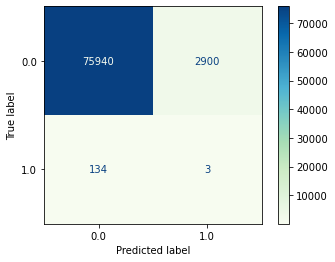

In [31]:
plot_confusion_matrix(rfp, X_test, y_test, cmap='GnBu')
plt.show()

# Undersampled Training Data

In [32]:
%%memit

t=Stopwatch()

rfp.fit(X_res, y_res)

print(t.stop())

240.77463797689416
peak memory: 10976.39 MiB, increment: 5112.09 MiB


In [33]:
y_preds = rfp.predict(X_test)

In [34]:
f1_score(y_test, y_preds)

0.0030557677616501145

/data/home/bt211037/.conda/envs/ondem_env/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


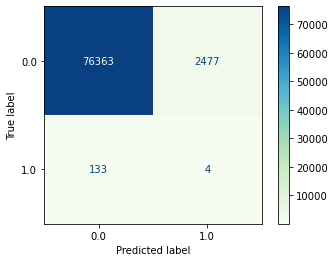

In [35]:
plot_confusion_matrix(rfp, X_test, y_test, cmap='GnBu')
plt.show()